In [1]:
from quspin.operators import hamiltonian
from quspin.operators import commutator# Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis
import numpy as np # generic math functions
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def Ham_nonint(L):
    basis = spin_basis_1d(L)
    hz=(np.sqrt(5)+1)/4 #parameters used by Kim and Huse
    hx=(np.sqrt(5)+5)/8
    J=1.0
    hz_arr = [[hz,i] for i in range(L)] 
    hx_arr = [[hx,i] for i in range(L)] 
    J_arr =[[J,i,(i+1)] for i in range(L-1)] # OBC  [[J,i,(i+1)%L] for i in range(L)] # PBC
    
    # static and dynamic lists
    static = [["zz",J_arr],["z",hz_arr], ["x",hx_arr] ]
    dynamic =[]
    H = hamiltonian(static,dynamic,basis=basis,dtype=np.complex_,check_symm=False,check_herm=False)
    return H

def Ham_int_antiferro(L,hz):
    basis = spin_basis_1d(L)
    J=1.0
    hz_arr = [[hz,i] for i in range(L)] # OBC
    J_arr =[[J,i,(i+1)] for i in range(L-1)] # OBC# [[J,i,(i+1)%L] for i in range(L)] # PBC
    # static and dynamic lists
    static = [["zz",J_arr],["x",hz_arr]]
    dynamic =[]
    H = hamiltonian(static,dynamic,basis=basis,dtype=np.complex_,check_symm=False,check_herm=False)
    return H

In [4]:
def del_lambda_Ham(L):
    basis = spin_basis_1d(L)  
    hx_lamb=1.0
    hx_lamb_arr = [[hx_lamb,i] for i in range(L)] 
    static_lamb = [["x",hx_lamb_arr]]
    dynamic_lamb =[]
    op_lamb=hamiltonian(static_lamb,dynamic_lamb,basis=basis,dtype=np.complex_,check_symm=False,check_herm=False)
    return op_lamb

def norm(A_lamb):    
    return np.linalg.norm(A_lamb, 'fro')

def guage_potent_mu(Ham,L, mu):
    E,V= Ham.eigh()
    op_lamb= del_lambda_Ham(L)
    wij = np.outer(E,np.ones(2**L))-np.outer(np.ones(2**L),E)
    num_lamb = np.dot(V,np.dot(op_lamb.toarray(),np.conj(V)))
    A_lamb = -1j*num_lamb*wij/(wij**2+ mu**2)
    return A_lamb

In [5]:
def new_gauge_potent_mu(Ham,L, mu):
    E,V= Ham.eigh()
    V_mat=np.matrix(V)
    V_mat_H=V_mat.H
    op_lamb_mat = np.matrix(del_lambda_Ham(L).toarray())
    num_lamb_mat =  (V_mat_H)*(op_lamb_mat*V_mat) #matrix multiplication
    wij = np.outer(E,np.ones(2**L))-np.outer(np.ones(2**L),E)
    A_lamb = -1j*np.multiply(wij,num_lamb_mat)/(wij**2+ mu**2)#element-wise multiplication
    return A_lamb

### Analytical formula: trace of $[H, \partial_{\lambda}H]$

In [8]:
#integrbale model
L=6
hz=5
Ham=Ham_int_antiferro(L,hz)
partial_lamb_H=del_lambda_Ham(L)
comm=commutator(Ham,partial_lamb_H)
mat=((-1j*comm)**2).toarray()
print np.trace(mat)/2**L, 4*2*(L-1)

(40+0j) 40


In [9]:
#non-integrbale model
L=6
Ham=Ham_nonint(L)
partial_lamb_H=del_lambda_Ham(L)
comm=commutator(Ham,partial_lamb_H)
mat=((-1j*comm)**2).toarray()
hz=(np.sqrt(5)+1)/4 
print " num,th:", np.trace(mat)/2**L, 4*(L*hz**2+2*(L-1))

 num,th: (55.7082039325+0j) 55.7082039325


### Numerical value: integrable

In [10]:
muTot=100
L=6
hz=5
norm_arr_int_old=np.zeros(muTot)
mu_arr=np.logspace(-5,10,muTot)
H=Ham_int_antiferro(L,hz)
for i in range(muTot):
    mu=mu_arr[i]
    A_lamb=guage_potent_mu(H,L,mu)
    norm_arr_int_old[i]=norm(A_lamb)

In [6]:
muTot=100
L=6
hz=5
norm_arr_int=np.zeros(muTot)
mu_arr=np.logspace(-5,20,muTot)
H=Ham_int_antiferro(L,hz)
for i in range(muTot):
    mu=mu_arr[i]
    A_lamb=new_gauge_potent_mu(H,L,mu)
    norm_arr_int[i]=norm(A_lamb)

In [7]:
E,V= H.eigh()
wij = np.outer(E,np.ones(2**L))-np.outer(np.ones(2**L),E)
index_lower = np.tril_indices(2**L,-1)
wij_arr=wij[index_lower]
print min(wij_arr), max(wij_arr)

0.0953783318915 60.5007524586


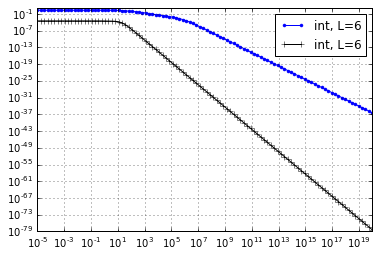

In [14]:
plt.loglog(mu_arr,norm_arr_int_old**2/2**6, 'b.-', label='int, L=6')
plt.loglog(mu_arr,norm_arr_int**2/2**6, 'k+-', label='int, L=6')
#plt.loglog(mu_arr[80:],norm_arr_int_old[80:]**2/2**6, 'k+-', label='int, L=6')
#plt.loglog(mu_arr_L6,norm_arr_nonintL6/2**6, 'r.-', label='Non-int, L=6')
#plt.loglog(mu_arr_L6[40:100],norm_arr_nonintL6[40:100]/2**6, 'k+-', label='Non-int, L=6')
#plt.loglog(mu_arr_L8,norm_arr_nonintL8/2**8, 'g.-', label='Non-int, L=8')
#plt.loglog(mu_arr_L8[20:50],norm_arr_nonintL8[20:50]/2**8, 'k+-', label='Non-int, L=8')
plt.legend(loc='best')
plt.grid()

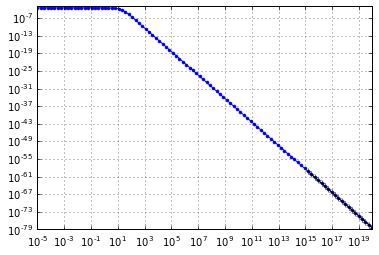

In [15]:
plt.loglog(mu_arr,norm_arr_int**2/2**6, 'b.-', label='int, L=6')
plt.loglog(mu_arr[80:],norm_arr_int[80:]**2/2**6, 'k+-', label='int, L=6')
plt.grid()

In [17]:
from scipy.optimize import curve_fit
def gfunc(x, a,c): #logfunction
    return a+ c*x
def org_func(x, a,c):
    return a*x**c
xdata =mu_arr[80:]
ydata = norm_arr_int[80:]**2/2**6
popt, pcov = curve_fit(gfunc, np.log(xdata), np.log(ydata))
print popt, np.diag(pcov)
a_in,b_in=popt
L=6
print " num,th:", np.exp(a_in), 4*2*(L-1), np.exp(a_in)/(4*2*(L-1))
print " log of num,th:", a_in, np.log(4*2*(L-1))

[ 3.68887945 -4.        ] [  5.94164519e-27   3.59283897e-30]
 num,th: 40.0 40 1.0
 log of num,th: 3.68887945411 3.68887945411


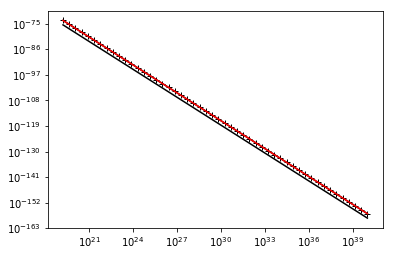

In [21]:
plt.loglog(mu_arr[50:100],norm_arr_int[50:100]**2/2**4, 'k+-', label='Non-int, L=4')
plt.loglog(mu_arr[50:100],org_func(mu_arr[50:100], np.exp(a_in),b_in,), 'r-', label='Non-int, L=4')
plt.loglog(mu_arr[50:100],org_func(mu_arr[50:100], 24.0,b_in,), 'k-', label='Non-int, L=4')

### Numerical value: non-integrable

In [22]:
muTot=100
L=6
norm_arr_nonint=np.zeros(muTot)
mu_arr=np.logspace(-5,10,muTot)
H=Ham_nonint(L)
for i in range(muTot):
    mu=mu_arr[i]
    A_lamb=guage_potent_mu(H,L,mu)
    norm_arr_nonint[i]=norm(A_lamb)

In [23]:
muTot=100
L=6
norm_arr_nonint_new=np.zeros(muTot)
mu_arr=np.logspace(-5,10,muTot)
H=Ham_nonint(L)
for i in range(muTot):
    mu=mu_arr[i]
    A_lamb=new_gauge_potent_mu(H,L,mu)
    norm_arr_nonint_new[i]=norm(A_lamb)

In [24]:
L=6
H=Ham_nonint(L)
E,V= H.eigh()
wij = np.outer(E,np.ones(2**L))-np.outer(np.ones(2**L),E)
index_lower = np.tril_indices(2**L,-1)
wij_arr=wij[index_lower]
print min(wij_arr), max(wij_arr), len(E)

0.00172247690936 18.2585719543 64


In [56]:
L=12
H=Ham_nonint(L)
E,V= H.eigh()
wij = np.outer(E,np.ones(2**L))-np.outer(np.ones(2**L),E)
index_lower = np.tril_indices(2**L,-1)
wij_arr=wij[index_lower]
print min(wij_arr), max(wij_arr)

2.30793233413e-08 37.5791979082


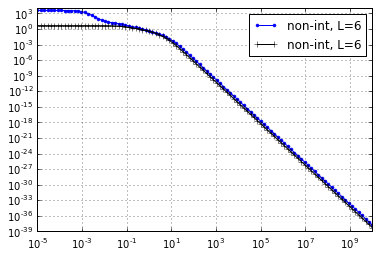

In [25]:
plt.loglog(mu_arr,norm_arr_nonint**2/2**6, 'b.-', label='non-int, L=6')
plt.loglog(mu_arr,norm_arr_nonint_new**2/2**6, 'k+-', label='non-int, L=6')
#plt.loglog(mu_arr[80:],norm_arr_nonint_new[80:]**2/2**6, 'r+-', label='Non-int, L=6')
#plt.loglog(mu_arr_L6,norm_arr_nonintL6/2**6, 'r.-', label='Non-int, L=6')
#plt.loglog(mu_arr_L6[40:100],norm_arr_nonintL6[40:100]/2**6, 'k+-', label='Non-int, L=6')
#plt.loglog(mu_arr_L8,norm_arr_nonintL8/2**8, 'g.-', label='Non-int, L=8')
#plt.loglog(mu_arr_L8[20:50],norm_arr_nonintL8[20:50]/2**8, 'k+-', label='Non-int, L=8')
plt.legend(loc='best')
plt.grid()

In [27]:
from scipy.optimize import curve_fit
def gfunc(x, a,c): #logfunction
    return a+ c*x
def org_func(x, a,c):
    return a*x**c
xdata =mu_arr[80:]
ydata = norm_arr_nonint_new[80:]**2/2**6
popt, pcov = curve_fit(gfunc, np.log(xdata), np.log(ydata))
print popt, np.diag(pcov)
a_in,b_in=popt
hz=(np.sqrt(5)+1)/4 
L=6
print " num,th:", np.exp(a_in), 4*(L*hz**2+2*(L-1))

[ 4.02012742 -4.        ] [  2.46105823e-26   6.26875518e-29]
 num,th: 55.7082039325 55.7082039325


In [28]:
def alpha_fun(norm_gauge_potent,mu,L):
    return mu**4*(norm_gauge_potent**2/2**L)

In [31]:
L=6
for i in range(20):
    print i,alpha_fun(norm_arr_nonint_new[80+i],mu_arr[80+i],L), mu_arr[80+i]

0 55.7082039325 13219411.4847
1 55.7082039325 18738174.2286
2 55.7082039325 26560877.8295
3 55.7082039325 37649358.0679
4 55.7082039325 53366992.3121
5 55.7082039325 75646332.7555
6 55.7082039325 107226722.201
7 55.7082039325 151991108.295
8 55.7082039325 215443469.003
9 55.7082039325 305385550.883
10 55.7082039325 432876128.108
11 55.7082039325 613590727.341
12 55.7082039325 869749002.618
13 55.7082039325 1232846739.44
14 55.7082039325 1747528400.01
15 55.7082039325 2477076355.99
16 55.7082039325 3511191734.22
17 55.7082039325 4977023564.33
18 55.7082039325 7054802310.72
19 55.7082039325 10000000000.0


### Numerical value: integrable with periodic boundary condition

In [16]:
muTot=100
L=4
hz=5
norm_arr_int=np.zeros(muTot)
mu_arr=np.logspace(-2,40,muTot)
H=Ham_int_antiferro(L,hz)
for i in range(muTot):
    mu=mu_arr[i]
    A_lamb=guage_potent_mu(H,L,mu)
    norm_arr_int[i]=norm(A_lamb)

In [15]:
E,V= H.eigh()
wij = np.outer(E,np.ones(2**L))-np.outer(np.ones(2**L),E)
index_lower = np.tril_indices(2**L,-1)
wij_arr=wij[index_lower]
print min(wij_arr), max(wij_arr)

0.133591984952 40.3002473846


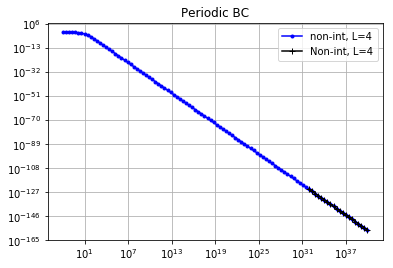

In [21]:
plt.loglog(mu_arr,norm_arr_int**2/2**4, 'b.-', label='non-int, L=4')
plt.loglog(mu_arr[80:],norm_arr_int[80:]**2/2**4, 'k+-', label='Non-int, L=4')
plt.title("Periodic BC")
plt.legend(loc='best')
plt.grid()

In [22]:
from scipy.optimize import curve_fit
def gfunc(x, a,c): #logfunction
    return a+ c*x
def org_func(x, a,c):
    return a*x**c
xdata =mu_arr[80:]
ydata = norm_arr_int[80:]**2/2**4
popt, pcov = curve_fit(gfunc, np.log(xdata), np.log(ydata))
print popt, np.diag(pcov)
a_in,b_in=popt
L=4
print " num,th:", np.exp(a_in), 4*2*(L), np.exp(a_in)/(4*2*(L-1)), np.log(82)
print " log of num,th:", a_in, np.log(4*2*(L))

[ 7.15169521 -4.        ] [  7.79786535e-27   1.13153153e-30]
 num,th: 1276.2676677 32 53.1778194875 4.40671924726
 log of num,th: 7.15169521283 3.4657359028


### ZZX Hamiltonian's exact gauge potential for L=3

In [18]:
def Ham_int_zzx(L):
    basis = spin_basis_1d(L)
    J=1.0
    hx=10.0
    hx_arr = [[0, 0], [hx, 1], [0, 2]]
    J_arr =[[J,i,(i+1)] for i in range(L-1)] # OBC
    # static and dynamic lists
    static = [["zz",J_arr],["x",hx_arr]]
    dynamic =[]
    H = hamiltonian(static,dynamic,basis=basis,dtype=np.complex_,check_symm=False,check_herm=False)
    return H

def del_lambda_zzxHam(L):
    basis = spin_basis_1d(L)  
    hx_lamb=1.0
    hx_lamb_arr =[[0, 0], [hx_lamb, 1], [0, 2]] 
    static_lamb = [["x",hx_lamb_arr]]
    dynamic_lamb =[]
    op_lamb=hamiltonian(static_lamb,dynamic_lamb,basis=basis,dtype=np.complex_,check_symm=False,check_herm=False)
    return op_lamb

def norm(A_lamb):    
    return np.linalg.norm(A_lamb, 'fro')

def guage_potent_mu(Ham,L, mu):
    E,V= Ham.eigh()
    op_lamb= del_lambda_zzxHam(L).toarray()
    wij = np.outer(E,np.ones(2**L))-np.outer(np.ones(2**L),E)
    num_lamb = np.dot(np.conj(V),np.dot(op_lamb,V))
    A_lamb = -1j*num_lamb*wij/(wij**2+ mu**2)
    return A_lamb

def new_gauge_potent_mu(Ham,L, mu):
    E,V= Ham.eigh()
    V_mat=np.matrix(V)
    V_mat_H=V_mat.H
    op_lamb_mat = np.matrix(del_lambda_zzxHam(L).toarray())
    num_lamb_mat =  (V_mat_H)*(op_lamb_mat*V_mat) #matrix multiplication
    wij = np.outer(E,np.ones(2**L))-np.outer(np.ones(2**L),E)
    A_lamb = -1j*np.multiply(wij,num_lamb_mat)/(wij**2+ mu**2)#element-wise multiplication
    return A_lamb

In [21]:
L=3
H=Ham_int_zzx(L)
print norm(H.toarray())**2/2**3
mat_Ham=(H**2).toarray()
print np.trace(mat_Ham)/2**3
E,V= H.eigh()

102.0
(102+0j)


In [42]:
#WRONG GAUGE POTENTIAL FUNCTION
h=10.0
mu=2.0
L=3
H=Ham_int_zzx(L)
A_lamb=guage_potent_mu(H,L,mu)
alpha2=4*(4.0+h**2)
print norm(A_lamb)**2/2**3, 8.0/(alpha2+mu**2)**2

0.00183195617917 4.53514739229e-05


In [43]:
h=10.0
mu=2.0
L=3
H=Ham_int_zzx(L)
A_lamb=new_gauge_potent_mu(H,L,mu)
alpha2=4*(4.0+h**2)
print norm(A_lamb)**2/2**3, 8.0/(alpha2+mu**2)**2

4.53514739229e-05 4.53514739229e-05


In [44]:
from numpy import linalg as LA
mat_A_lamb=np.matrix(A_lamb)
mat_A_lamb_transpose=mat_A_lamb.H
print np.trace(mat_A_lamb*mat_A_lamb_transpose)/2**3

(4.53514739229e-05+0j)


In [45]:
def A_lambda_byhand(L,mu):
    basis = spin_basis_1d(L)
    h=10.0
    alpha2=2*(4.0+h**2)+ mu**2/2.0
    J1_arr =[[1./alpha2, 0,1], [0,1,2]]
    J2_arr =[[0,0,1],[1./alpha2, 1,2]]
    static_lamb = [["zy",J1_arr],["yz",J2_arr]]
    dynamic_lamb =[]
    op_lamb=hamiltonian(static_lamb,dynamic_lamb,basis=basis,dtype=np.complex_,check_symm=False,check_herm=False)
    return op_lamb

In [46]:
L=3
mu=2.0
A_lambda_brute=A_lambda_byhand(L,mu)
print norm(A_lambda_brute.toarray())**2/2**3,8.0/(alpha2+mu**2)**2

4.53514739229e-05 4.53514739229e-05


### Trace of gauge potential to see what's going on

In [31]:
h=10.0
mu=2.0
L=3
H=Ham_int_zzx(L)
A_lamb=np.matrix(new_gauge_potent_mu(H,L,mu))
A_lambda_brute=np.matrix(A_lambda_byhand(L,mu).toarray())

In [33]:
print np.trace(A_lamb*A_lambda_brute)

0j


In [34]:
def singlebody(L):
    basis = spin_basis_1d(L)
    J=1.0
    J_arr =[[J,i] for i in range(L)]
    static_lamb = [["y",J_arr]]
    dynamic_lamb =[]
    op_lamb=hamiltonian(static_lamb,dynamic_lamb,basis=basis,dtype=np.complex_,check_symm=False,check_herm=False)
    return op_lamb

In [35]:
def twobody(L):
    basis = spin_basis_1d(L)
    J=1.0
    J_arr =[[J,i,i+1] for i in range(L-1)]
    static_lamb = [["yy",J_arr]]
    dynamic_lamb =[]
    op_lamb=hamiltonian(static_lamb,dynamic_lamb,basis=basis,dtype=np.complex_,check_symm=False,check_herm=False)
    return op_lamb

In [36]:
def twobodyYZ(L):
    basis = spin_basis_1d(L)
    J=1.0
    J_arr =[[J,i,i+1] for i in range(L-1)]
    static_lamb = [["yz",J_arr]]
    dynamic_lamb =[]
    op_lamb=hamiltonian(static_lamb,dynamic_lamb,basis=basis,dtype=np.complex_,check_symm=False,check_herm=False)
    return op_lamb

In [37]:
def threebodyXYZ(L):
    basis = spin_basis_1d(L)
    J=1.0
    J_arr =[[J,i,i+1,i+2] for i in range(L-2)]
    static_lamb = [["xyz",J_arr]]
    dynamic_lamb =[]
    op_lamb=hamiltonian(static_lamb,dynamic_lamb,basis=basis,dtype=np.complex_,check_symm=False,check_herm=False)
    return op_lamb

In [38]:
L=3 ##sanity check
T1=np.mat(singlebody(L).toarray())
T2=np.mat(twobody(L).toarray())
T3=np.mat(twobodyYZ(L).toarray())
T4=np.mat(threebodyXYZ(L).toarray())
print np.trace(T1*T1)
print np.trace(T2*T2)
print np.trace(T3*T3)
print np.trace(T1*T2)
print np.trace(T1*T3)
print np.trace(T2*T3)
print np.trace(T2*T4)

(24+0j)
(16+0j)
(16+0j)
0j
0j
0j
0j


In [39]:
T1=np.mat(singlebody(L).toarray())
T2=np.mat(twobody(L).toarray())

mu=2.0
L=3
H=Ham_int_zzx(L)
A_lamb=np.matrix(guage_potent_mu(H,L,mu))

In [40]:
print np.trace(T1*A_lamb)
print np.trace(T2*A_lamb)
print np.trace(T3*A_lamb)
print np.trace(T4*A_lamb)

(0.043959221293+0j)
0.00500922341531j
(-0.0242523967084+0j)
(0.0240384615385+0j)


### 1 body Hamiltonian
$H=\sigma_z + \lambda \sigma_x$ . $A_{\lambda}= \sigma_y/(2+ 2 \lambda^2)$

In [4]:
def Ham(L):
    basis = spin_basis_1d(L)
    hz=5.0
    hx=10.0
    hz_arr = [[hz,i] for i in range(L)] # OBC
    hx_arr = [[hx,i] for i in range(L)] # OBC
    # static and dynamic lists
    static = [["z",hz_arr], ["x",hx_arr] ]
    dynamic =[]
    H = hamiltonian(static,dynamic,basis=basis,dtype=np.complex_)
    return H


def del_lambda_Ham_single(L):
    basis = spin_basis_1d(L)
    hx_lamb=1.0
    hx_lamb_arr = [[hx_lamb,i] for i in range(L)] # OBC
    static_lamb = [["x",hx_lamb_arr]]
    dynamic_lamb =[]
    op_lamb=hamiltonian(static_lamb,dynamic_lamb,basis=basis,dtype=np.complex_)
    return op_lamb

def gauge_potent_mu_1body(Ham,L, mu):
    E,V= Ham.eigh()
    op_lamb= del_lambda_Ham_single(L).toarray()
    wij = np.outer(E,np.ones(2**L))-np.outer(np.ones(2**L),E)
    num_lamb = np.dot(np.conj(V),np.dot(op_lamb,V))
    A_lamb = -1j*num_lamb*wij/(wij**2+ mu**2)
    return A_lamb

In [5]:
def new_gauge_potent_mu_1body(Ham,L, mu):
    E,V= Ham.eigh()
    V_mat=np.matrix(V)
    V_mat_H=V_mat.H
    op_lamb_mat = np.matrix(del_lambda_Ham_single(L).toarray())
    num_lamb_mat =  (V_mat_H)*(op_lamb_mat*V_mat)
    wij = np.outer(E,np.ones(2**L))-np.outer(np.ones(2**L),E)
    A_lamb = -1j*np.multiply(wij,num_lamb_mat)/(wij**2+ mu**2)
    return A_lamb

In [7]:
L=1
H=Ham(L)
E,V= H.eigh()
#V_mat=np.matrix(V)
#V_mat_H=V_mat.H
#op_lamb_mat = np.matrix(del_lambda_Ham_single(L).toarray())
#num_lamb_mat =  (V_mat_H)*(op_lamb_mat*V_mat)
#wij = np.outer(E,np.ones(2**L))-np.outer(np.ones(2**L),E)
print V[:,0]
print V[:,1]
#print num_lamb_mat
#print np.multiply(wij,num_lamb_mat)/(wij**2+ mu**2)

Hermiticity check passed!
Symmetry checks passed!
[-0.85065081+0.j  0.52573111+0.j]
[ 0.52573111+0.j  0.85065081+0.j]


In [8]:
print V

[[-0.85065081+0.j  0.52573111+0.j]
 [ 0.52573111+0.j  0.85065081+0.j]]


In [298]:
mu=2.0
L=1
H=Ham(L)
A_lamb=guage_potent_mu_1body(H,L,mu)
print A_lamb

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
[[ 0.+0.j         -0.-0.01984127j]
 [ 0.+0.01984127j  0.+0.j        ]]


In [299]:
A_lamb=new_gauge_potent_mu_1body(H,L,mu)
print A_lamb

Hermiticity check passed!
Symmetry checks passed!
[[ 0.+0.j          0.-0.01984127j]
 [ 0.+0.01984127j  0.+0.j        ]]


In [232]:
hz=5.0
hx=10.0
mu=2.0
alpha2=4*(hz**2+hx**2)
print 2.0*hz/(alpha2+mu**2)

0.0198412698413


### 2 body Hamiltonian
$H=\sigma^z_0 \sigma^z_1 + \lambda \sigma^x_0$ and $A_{\lambda}=2/(\alpha^2+ \mu^2)  \sigma^y_0 \sigma^z_1$ where $\alpha^2= 4(1+ \lambda^2)$

In [2]:
def Ham2B(L):
    basis = spin_basis_1d(L)
    J=1.0
    hx=10.0
    J_arr = [[J,i,i+1] for i in range(L-1)] # OBC
    hx_arr = [[hx,0], [0,1]] # OBC
    # static and dynamic lists
    static = [["zz",J_arr], ["x",hx_arr] ]
    dynamic =[]
    H = hamiltonian(static,dynamic,basis=basis,dtype=np.complex_)
    return H


def del_lambda2B(L):
    basis = spin_basis_1d(L)
    hx=1.0
    hx_arr = [[hx,0], [0,1]] # OBC
    static_lamb = [["x",hx_arr]]
    dynamic_lamb =[]
    op_lamb=hamiltonian(static_lamb,dynamic_lamb,basis=basis,dtype=np.complex_)
    return op_lamb

def gauge_potent_mu_2B(Ham,L, mu):
    E,V= Ham.eigh()
    V_mat=np.matrix(V)
    V_mat_H=V_mat.H
    op_lamb = np.matrix(del_lambda2B(L).toarray())
    num_lamb =  (V_mat_H)*(op_lamb*V_mat) #np.dot(np.conj(V),np.dot(op_lamb,V))
    wij = np.outer(E,np.ones(2**L))-np.outer(np.ones(2**L),E)
    A_lamb = -1j*num_lamb*wij/(wij**2+ mu**2)
    return A_lamb

def new_gauge_potent_mu_2B(Ham,L, mu):
    E,V= Ham.eigh()
    V_mat=np.matrix(V)
    V_mat_H=V_mat.H
    op_lamb_mat = np.matrix(del_lambda2B(L).toarray())
    num_lamb_mat =  (V_mat_H)*(op_lamb_mat*V_mat)
    wij = np.outer(E,np.ones(2**L))-np.outer(np.ones(2**L),E)
    A_lamb = -1j*np.multiply(wij,num_lamb_mat)/(wij**2+ mu**2)
    return A_lamb

In [15]:
L=2
Ham=Ham2B(L)

E,V= Ham.eigh()
wij = np.outer(E,np.ones(2**L))-np.outer(np.ones(2**L),E)

index_lower = np.tril_indices(2**L,-1)
wij_arr=wij[index_lower]
print wij
wij_min_nonint= min(wij_arr)
print min(wij_arr)

Hermiticity check passed!
Symmetry checks passed!
[[  0.00000000e+00  -3.55271368e-15  -2.00997512e+01  -2.00997512e+01]
 [  3.55271368e-15   0.00000000e+00  -2.00997512e+01  -2.00997512e+01]
 [  2.00997512e+01   2.00997512e+01   0.00000000e+00   0.00000000e+00]
 [  2.00997512e+01   2.00997512e+01   0.00000000e+00   0.00000000e+00]]
0.0


In [49]:
L=2
H=Ham2B(L)
mu=2
print new_gauge_potent_mu_2B(H,L,mu)
A=new_gauge_potent_mu_2B(H,L,mu)

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
[[ 0.+0.j          0.+0.j          0.+0.j          0.+0.00490196j]
 [ 0.+0.j          0.+0.j          0.+0.00490196j  0.+0.j        ]
 [ 0.+0.j          0.-0.00490196j  0.+0.j          0.+0.j        ]
 [ 0.-0.00490196j  0.+0.j          0.+0.j          0.+0.j        ]]
Hermiticity check passed!
Symmetry checks passed!


In [14]:
def gauge_by_hand(L,mu):
    basis = spin_basis_1d(L)
    h=10.0
    alpha=np.sqrt(4*(1+h**2))
    J=2/(alpha**2+mu**2)
    hx=10.0
    J_arr = [[J,0,1]]
    # static and dynamic lists
    static = [["yz",J_arr]]
    dynamic =[]
    H = hamiltonian(static,dynamic,basis=basis,dtype=np.complex_)
    return H

In [52]:
L=2
mu=2
print gauge_by_hand(L,mu).toarray()
B=gauge_by_hand(L,mu).toarray()

Hermiticity check passed!
Symmetry checks passed!
[[ 0.+0.j          0.-0.00490196j  0.+0.j          0.+0.j        ]
 [ 0.+0.00490196j  0.+0.j          0.+0.j          0.+0.j        ]
 [ 0.+0.j          0.+0.j          0.+0.j          0.+0.00490196j]
 [ 0.+0.j          0.+0.j          0.-0.00490196j  0.+0.j        ]]
Hermiticity check passed!
Symmetry checks passed!


In [53]:
#analytical formula
h=10.0
alpha=np.sqrt(4*(1+h**2))
J=2/(alpha**2+mu**2)
print J

0.00490196078431


In [58]:
A_mat=np.matrix(A)
B_mat=np.matrix(B)
print np.trace(A_mat.H*B_mat)/2**2

0j


In [57]:
print (A_mat.H)*B_mat

[[  0.00000000e+00+0.j   0.00000000e+00+0.j   2.40292195e-05+0.j
    0.00000000e+00+0.j]
 [  0.00000000e+00+0.j   0.00000000e+00+0.j   0.00000000e+00+0.j
   -2.40292195e-05+0.j]
 [  2.40292195e-05+0.j   0.00000000e+00+0.j   0.00000000e+00+0.j
    0.00000000e+00+0.j]
 [  0.00000000e+00+0.j  -2.40292195e-05+0.j   0.00000000e+00+0.j
    0.00000000e+00+0.j]]
